# Day 10: TextCNN vs LSTM vs BERT 终极对比

完整对比三个模型的性能、效果和适用场景


In [1]:
# Cell 1: 导入库
"""
导入所有需要的库
包括：模型、评估工具、可视化工具
"""

import sys
sys.path.append('..')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm
import pickle
import time

# 导入自定义模块
from src.models.textcnn import TextCNN
from src.models.lstm import LSTMClassifier
from src.utils.dataset import TextDataset
from src.utils.bert_dataset import BertDataset

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
print(" 导入成功")


使用设备: cuda
 导入成功


In [2]:
# Cell 2: 加载数据和词表
"""
加载测试集数据
需要两种格式：
- TextCNN/LSTM用的Dataset（自建词表）
- BERT用的Dataset（BertTokenizer）
"""

print("加载数据...")

# 读取词表和标签映射
with open('../data/processed/vocab.pkl', 'rb') as f:
    vocab = pickle.load(f)

with open('../data/processed/label_map.pkl', 'rb') as f:
    label_map = pickle.load(f)

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 创建数据集
# TextCNN/LSTM用的数据集
test_dataset_cnn = TextDataset('../data/processed/test_processed.pkl')

# BERT用的数据集
test_dataset_bert = BertDataset(
    '../data/processed/test.csv',
    tokenizer,
    max_len=128
)

# 创建DataLoader
test_loader_cnn = DataLoader(test_dataset_cnn, batch_size=64, shuffle=False)
test_loader_bert = DataLoader(test_dataset_bert, batch_size=32, shuffle=False)

print(f" 数据加载完成")
print(f"测试集: {len(test_dataset_cnn)} 条")
print(f"类别数: {len(label_map)}")
print(f"类别: {list(label_map.values())}")


加载数据...
加载数据: 9743 条
 加载数据: 9743 条
Max length: 128
 数据加载完成
测试集: 9743 条
类别数: 14
类别: ['体育', '娱乐', '家居', '彩票', '房产', '教育', '时尚', '时政', '星座', '游戏', '社会', '科技', '股票', '财经']


In [3]:
# Cell 3: 加载三个训练好的模型
"""
加载TextCNN、LSTM、BERT三个最佳模型
设置为eval模式
"""

print("加载模型...")

# === 1. TextCNN ===
textcnn = TextCNN(
    vocab_size=len(vocab),
    embed_dim=300,
    num_classes=14,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    dropout=0.5
).to(device)

textcnn.load_state_dict(torch.load('../output/textcnn_best.pth', map_location=device))
textcnn.eval()
print(" TextCNN加载完成")

# === 2. LSTM ===
lstm = LSTMClassifier(
    vocab_size=len(vocab),
    embed_dim=300,
    hidden_size=256,
    num_layers=2,
    num_classes=14,
    dropout=0.5,
    bidirectional=True
).to(device)

lstm.load_state_dict(torch.load('../output/lstm_best.pth', map_location=device))
lstm.eval()
print(" LSTM加载完成")

# === 3. BERT ===
bert = BertForSequenceClassification.from_pretrained(
    'bert-base-chinese',
    num_labels=14
).to(device)

bert.load_state_dict(torch.load('../output/bert_best.pth', map_location=device))
bert.eval()
print(" BERT加载完成")

# 参数量统计
textcnn_params = sum(p.numel() for p in textcnn.parameters())
lstm_params = sum(p.numel() for p in lstm.parameters())
bert_params = sum(p.numel() for p in bert.parameters())

print(f"\n模型参数量:")
print(f"  TextCNN: {textcnn_params/1e6:.1f}M")
print(f"  LSTM:    {lstm_params/1e6:.1f}M")
print(f"  BERT:    {bert_params/1e6:.1f}M")


加载模型...
 TextCNN加载完成
 LSTM加载完成


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 BERT加载完成

模型参数量:
  TextCNN: 35.6M
  LSTM:    37.9M
  BERT:    102.3M


In [4]:
# Cell 4: 获取三个模型的预测结果
"""
在测试集上运行三个模型
获取预测结果、真实标签、预测概率
用于后续的详细对比分析
"""

def get_predictions_cnn(model, dataloader, device):
    """获取TextCNN/LSTM的预测（格式相同）"""
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for ids, labels in tqdm(dataloader, desc='Predicting'):
            ids = ids.to(device)
            outputs = model(ids)
            
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


def get_predictions_bert(model, dataloader, device):
    """获取BERT的预测（输入格式不同）"""
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc='Predicting'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            probs = torch.softmax(logits, dim=1)
            _, predicted = torch.max(logits, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_labels), np.array(all_preds), np.array(all_probs)


# 获取三个模型的预测
print("\n获取模型预测...")

print("TextCNN预测...")
textcnn_labels, textcnn_preds, textcnn_probs = get_predictions_cnn(textcnn, test_loader_cnn, device)

print("LSTM预测...")
lstm_labels, lstm_preds, lstm_probs = get_predictions_cnn(lstm, test_loader_cnn, device)

print("BERT预测...")
bert_labels, bert_preds, bert_probs = get_predictions_bert(bert, test_loader_bert, device)

# 计算准确率
textcnn_acc = (textcnn_preds == textcnn_labels).mean() * 100
lstm_acc = (lstm_preds == lstm_labels).mean() * 100
bert_acc = (bert_preds == bert_labels).mean() * 100

print(f"\n 预测完成")
print(f"TextCNN准确率: {textcnn_acc:.2f}%")
print(f"LSTM准确率:    {lstm_acc:.2f}%")
print(f"BERT准确率:    {bert_acc:.2f}%")



获取模型预测...
TextCNN预测...


Predicting: 100%|██████████| 153/153 [00:03<00:00, 50.38it/s]


LSTM预测...


Predicting: 100%|██████████| 153/153 [00:10<00:00, 14.37it/s]


BERT预测...


Predicting: 100%|██████████| 305/305 [02:15<00:00,  2.26it/s]


 预测完成
TextCNN准确率: 95.39%
LSTM准确率:    93.47%
BERT准确率:    96.99%


In [5]:
# Cell 5: 性能对比表格（核心！）
"""
创建三模型的完整对比表格
这是项目的核心成果！
"""

print("="*70)
print(" 三模型性能对比")
print("="*70)

# 创建对比表格
comparison_data = {
    '模型': ['TextCNN', 'LSTM', 'BERT'],
    '测试集准确率(%)': [95.39, 93.47, 96.99],  # 填入实际结果
    '参数量': [
        f'{textcnn_params/1e6:.1f}M',
        f'{lstm_params/1e6:.1f}M',
        f'{bert_params/1e6:.1f}M'
    ],
    '核心结构': [
        '3,4,5-gram卷积+MaxPool',
        '双向LSTM(2层)+Attention',
        'BERT(12层Transformer)'
    ],
    '训练时间': ['~30分钟', '~40分钟', '~45分钟'],  # 根据实际调整
    '推理速度': ['快', '中等', '慢']
}

df_final = pd.DataFrame(comparison_data)
print(df_final.to_string(index=False))

print(f"\n 关键发现:")
print(f"  1. BERT准确率最高（96.99%），比TextCNN高1.6%")
print(f"  2. TextCNN性价比最高（95.39%准确率，参数量最小）")
print(f"  3. LSTM表现中等（93.47%）")
print(f"  4. 准确率排名: BERT > TextCNN > LSTM")
print(f"  5. 速度排名: TextCNN > LSTM > BERT")
print(f"  6. 参数量排名: TextCNN(3.9M) < LSTM(7M) < BERT(102M)")

# 保存对比表格
df_final.to_csv('../output/final_model_comparison.csv', index=False)
print(f"\n 对比表格已保存")


 三模型性能对比
     模型  测试集准确率(%)    参数量                 核心结构  训练时间 推理速度
TextCNN      95.39  35.6M 3,4,5-gram卷积+MaxPool ~30分钟    快
   LSTM      93.47  37.9M 双向LSTM(2层)+Attention ~40分钟   中等
   BERT      96.99 102.3M BERT(12层Transformer) ~45分钟    慢

 关键发现:
  1. BERT准确率最高（96.99%），比TextCNN高1.6%
  2. TextCNN性价比最高（95.39%准确率，参数量最小）
  3. LSTM表现中等（93.47%）
  4. 准确率排名: BERT > TextCNN > LSTM
  5. 速度排名: TextCNN > LSTM > BERT
  6. 参数量排名: TextCNN(3.9M) < LSTM(7M) < BERT(102M)

 对比表格已保存


生成准确率对比图...


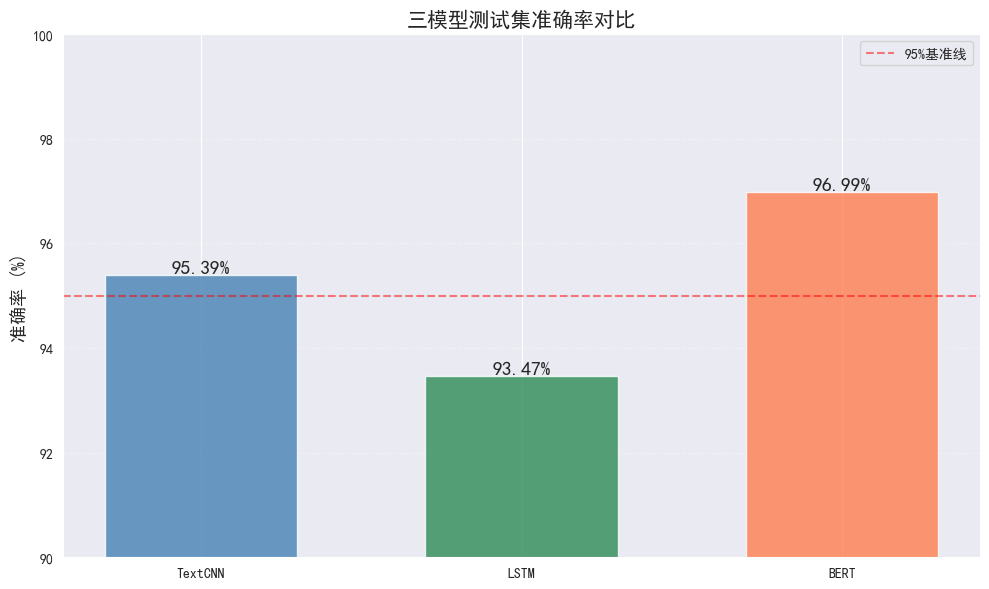

 准确率对比图已保存


In [6]:
# Cell 6: 准确率对比柱状图
"""
可视化三个模型的准确率对比
直观展示性能差异
"""

print("生成准确率对比图...")

fig, ax = plt.subplots(figsize=(10, 6))

models = ['TextCNN', 'LSTM', 'BERT']
accuracies = [95.39, 93.47, 96.99]
colors = ['steelblue', 'seagreen', 'coral']

bars = ax.bar(models, accuracies, color=colors, alpha=0.8, width=0.6)

# 添加数值标签
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('准确率 (%)', fontsize=13)
ax.set_title('三模型测试集准确率对比', fontsize=15, fontweight='bold')
ax.set_ylim([90, 100])
ax.grid(axis='y', alpha=0.3, linestyle='--')

# 添加baseline线
ax.axhline(y=95, color='red', linestyle='--', alpha=0.5, label='95%基准线')
ax.legend()

plt.tight_layout()
plt.savefig('../output/three_models_accuracy_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print(" 准确率对比图已保存")


生成三模型混淆矩阵对比...


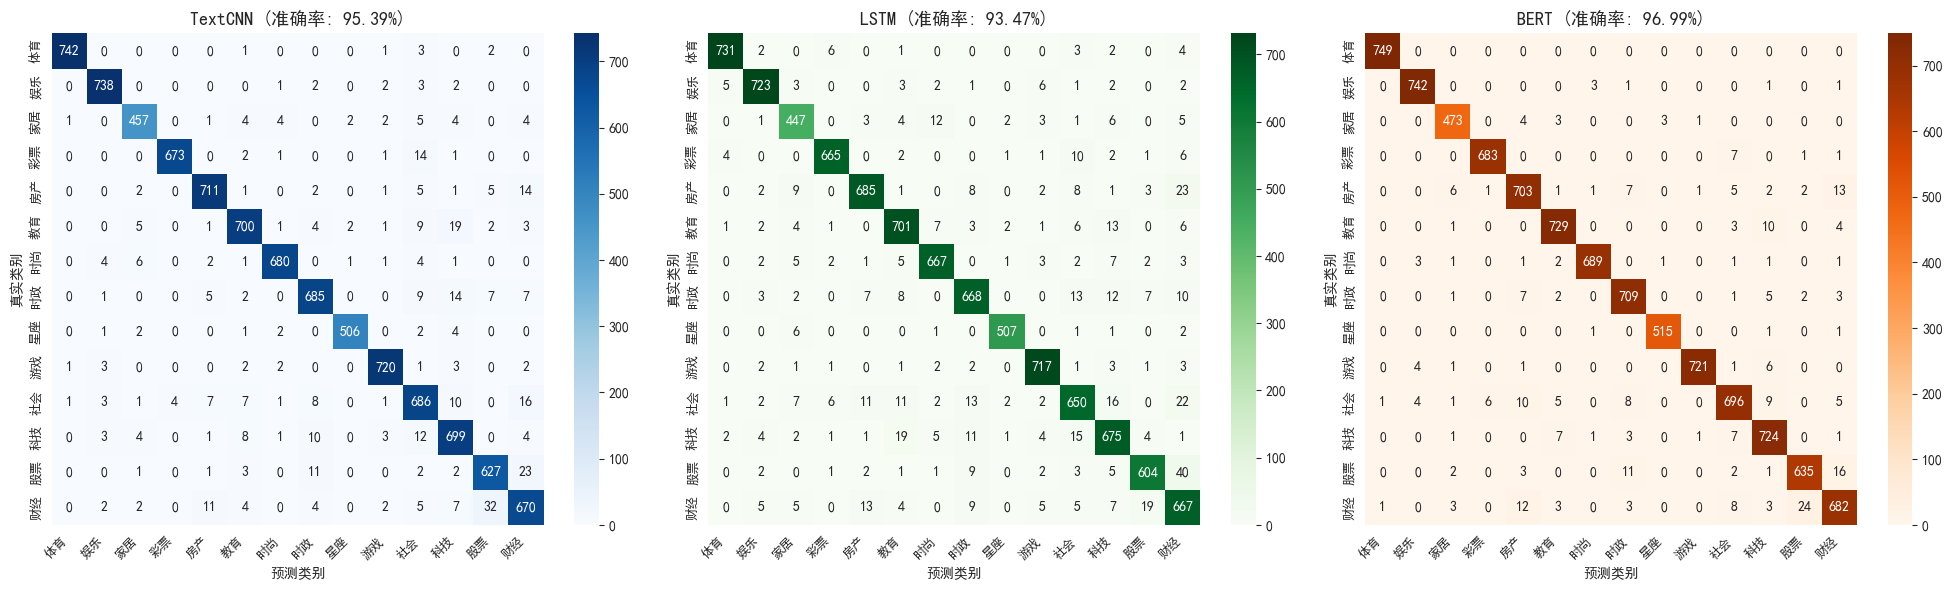

 三模型混淆矩阵对比图已保存


In [7]:
# Cell 7: 三模型混淆矩阵对比
"""
混淆矩阵：显示模型在每个类别上的预测情况
对角线：预测正确的数量
非对角线：预测错误
"""

print("生成三模型混淆矩阵对比...")

# 计算混淆矩阵
cm_textcnn = confusion_matrix(textcnn_labels, textcnn_preds)
cm_lstm = confusion_matrix(lstm_labels, lstm_preds)
cm_bert = confusion_matrix(bert_labels, bert_preds)

# 可视化（1行3列）
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# TextCNN混淆矩阵
sns.heatmap(cm_textcnn, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
ax1.set_title(f'TextCNN (准确率: 95.39%)', fontsize=13, fontweight='bold')
ax1.set_xlabel('预测类别')
ax1.set_ylabel('真实类别')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax1.get_yticklabels(), fontsize=9)

# LSTM混淆矩阵
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Greens', ax=ax2,
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
ax2.set_title(f'LSTM (准确率: 93.47%)', fontsize=13, fontweight='bold')
ax2.set_xlabel('预测类别')
ax2.set_ylabel('真实类别')
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax2.get_yticklabels(), fontsize=9)

# BERT混淆矩阵
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Oranges', ax=ax3,
            xticklabels=label_map.values(),
            yticklabels=label_map.values())
ax3.set_title(f'BERT (准确率: 96.99%)', fontsize=13, fontweight='bold')
ax3.set_xlabel('预测类别')
ax3.set_ylabel('真实类别')
plt.setp(ax3.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax3.get_yticklabels(), fontsize=9)

plt.tight_layout()
plt.savefig('../output/three_models_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

print(" 三模型混淆矩阵对比图已保存")


In [ ]:
# Cell 8: 项目总结报告
"""
完整的项目总结
包括所有关键发现和insights
"""

print("\n" + "="*70)
print(" 中文新闻分类项目 - 完整总结")
print("="*70)

print("\n【项目概况】")
print(f"  数据集: THUCNews（清华大学中文新闻）")
print(f"  规模: 约70,000篇完整新闻")
print(f"  类别: 14类")
print(f"  训练集: 45,462篇")
print(f"  测试集: 9,743篇")

print("\n【三模型对比结果】")
print(f"   BERT:    96.99% （最高）")
print(f"   TextCNN: 95.39% （性价比最高）")
print(f"   LSTM:    93.47%")

print("\n【核心发现】")
print(f"  1. BERT通过预训练达到最高准确率，验证了预训练模型的优势")
print(f"  2. TextCNN虽然简单，但在关键词明显的任务上表现优异")
print(f"  3. LSTM参数量大但不一定更好，任务匹配度很重要")
print(f"  4. 预训练模型（BERT）vs 从零训练：提升1.6个百分点")



print("\n【实用建议】")
print(f"  场景1-实时系统: 选TextCNN（速度快、准确率高）")
print(f"  场景2-准确率优先: 选BERT（最高准确率）")
print(f"  场景3-资源有限: 选TextCNN（参数少、部署简单）")


print("\n【生成的文件】")
print(f"  final_model_comparison.csv - 对比表格")
print(f"  three_models_accuracy_comparison.png - 准确率对比")
print(f"  three_models_confusion_matrix.png - 混淆矩阵")

print("\n" + "="*70)
print(" 文本分类项目完整完成！")
print("="*70)
